<a href="https://colab.research.google.com/github/Dena-Kazerani/stock-prediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import finance API and get historical stock data
!pip install yfinance
#!pip install -U scikit-learn
import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

# Save file to json in case we need it later.  This prevents us from having to re-download it every time.
msft_hist.to_json(DATA_PATH)

     |████████████████████████████████| 6.4 MB 14.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055949,0.064177,0.055949,0.061434,1031788800,0.0,0.0
1986-03-14,0.061434,0.064725,0.061434,0.063628,308160000,0.0,0.0
1986-03-17,0.063628,0.065274,0.063628,0.064725,133171200,0.0,0.0
1986-03-18,0.064725,0.065274,0.062531,0.063079,67766400,0.0,0.0
1986-03-19,0.063079,0.063628,0.061434,0.061982,47894400,0.0,0.0


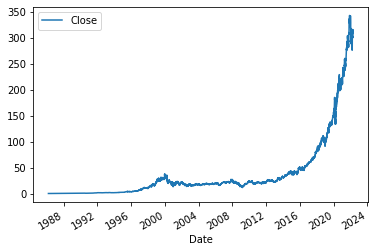

In [3]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [4]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [5]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [6]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

In [7]:
train.columns

Index(['Actual_Close', 'Target', 'Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')

# Hyperparameters tunings and application of tuned models on the data

In [8]:
!pip install optuna
import optuna
def best_trial(objective, nb_trials):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials= nb_trials)
  trial = study.best_trial
  print('Accuracy: {}'.format(trial.value))
  print("Best hyperparameters: {}".format(trial.params))
  return trial

def precision(model):
  # Evaluate error of predictions
  model.fit(train[predictors], train["Target"])
  preds= model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index)
  print(precision_score(test["Target"], preds))

     |████████████████████████████████| 308 kB 9.6 MB/s 
     |████████████████████████████████| 210 kB 50.3 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 150 kB 50.4 MB/s 
     |████████████████████████████████| 113 kB 51.7 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=35a24faeb79f0f79ed973596c88f8005069d3fb9c81b79ee3be99e9dddd6b66a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Decision Tree Classifier 







In [9]:
#Choose the range of convenient ccp_alpha
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(train[predictors], train["Target"])
ccp_alphas= path.ccp_alphas
print(type(ccp_alphas))

<class 'numpy.ndarray'>


In [10]:
#Use optuna for hyperparameter tuning
import sklearn
def objective_dtc(trial):
  max_depth = trial.suggest_int('max_depth', 10, 30)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  ccp_alpha = trial.suggest_categorical('ccp_alpha', ccp_alphas )
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, ccp_alpha = ccp_alpha, 
            criterion = criterion)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()

best_trial_dtc = best_trial(objective_dtc, 100)

[I 2022-04-07 20:22:45,795] A new study created in memory with name: no-name-672ff752-8a3b-488a-9ced-4e4f0c0b998c
[I 2022-04-07 20:22:50,100] Trial 0 finished with value: 0.4959937575009228 and parameters: {'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 8, 'ccp_alpha': 0.0001668149466192171, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4959937575009228.
[I 2022-04-07 20:22:51,507] Trial 1 finished with value: 0.49766128877679544 and parameters: {'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 20, 'ccp_alpha': 0.00017039334668076558, 'criterion': 'entropy'}. Best is trial 1 with value: 0.49766128877679544.
[I 2022-04-07 20:22:52,167] Trial 2 finished with value: 0.4942133839031818 and parameters: {'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 20, 'ccp_alpha': 0.0001429842399593289, 'criterion': 'gini'}. Best is trial 1 with value: 0.49766128877679544.
[I 2022-04-07 20:22:53,185] Trial 3 finished with value: 0.5009995665618211 and par

Accuracy: 0.5052247540810275
Best hyperparameters: {'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 2, 'ccp_alpha': 0.00017793594306049818, 'criterion': 'gini'}


In [17]:
# Evaluate error of predictions
from sklearn.metrics import precision_score
precision(DecisionTreeClassifier(**best_trial_dtc.params))

0.4810126582278481


# Random Forest Classifier 

In [ ]:
# Random forest hyperparameter tuning using optuna

def objective_rf(trial):
      n_estimators = trial.suggest_int('n_estimators', 100, 150)
      max_depth = int(trial.suggest_loguniform('max_depth', 10, 30))
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
      ccp_alpha = trial.suggest_categorical('ccp_alpha', ccp_alphas )
      criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
      clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha = ccp_alpha, 
            criterion = criterion)
      return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()

In [ ]:
best_trial_rf = best_trial(objective_rf, 100)

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 210 kB 42.6 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 113 kB 48.3 MB/s 
     |████████████████████████████████| 150 kB 54.6 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a3e504addf66fe92316d4283e66f626b9ef5456398bdb6928050a52f79938423
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


[I 2022-03-25 18:32:43,519] A new study created in memory with name: no-name-57665872-119f-44b3-ad7e-b98612be8500
[I 2022-03-25 18:32:45,641] Trial 0 finished with value: 0.4956037221154287 and parameters: {'n_estimators': 19, 'max_depth': 1.7909392792805008}. Best is trial 0 with value: 0.4956037221154287.
[I 2022-03-25 18:32:45,856] Trial 1 finished with value: 0.48858912342149063 and parameters: {'n_estimators': 9, 'max_depth': 1.8045517064593217}. Best is trial 0 with value: 0.4956037221154287.
[I 2022-03-25 18:32:46,086] Trial 2 finished with value: 0.4809045761743465 and parameters: {'n_estimators': 7, 'max_depth': 2.0735538660567796}. Best is trial 0 with value: 0.4956037221154287.
[I 2022-03-25 18:32:47,022] Trial 3 finished with value: 0.4829102079313084 and parameters: {'n_estimators': 13, 'max_depth': 12.820339772120128}. Best is trial 0 with value: 0.4956037221154287.
[I 2022-03-25 18:32:47,290] Trial 4 finished with value: 0.4976034668025031 and parameters: {'n_estimators'

In [ ]:
#Test the hyperparameter tuned random forest on test set 
from sklearn.ensemble import RandomForestClassifier
precision(RandomForestClassifier(**best_trial_rf.params, random_state=1))

0.48484848484848486

In [ ]:

from xgboost import XGBClassifier
def objective_xgb(trial):
  params={
          "n_estimators" : trial.suggest_int('n_estimators', 2, 1000),
          "max_depth": trial.suggest_int("max_depth", 1, 32),
          "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
          "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
          "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
          "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
          "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
          "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
          "n_jobs": 1,
  }
  clf = XGBClassifier(**params)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2022-03-25 18:50:34,377] A new study created in memory with name: no-name-84ed47fc-e945-4ae6-8314-a4a06e5d6182
[I 2022-03-25 18:50:36,402] Trial 0 finished with value: 0.47778889091321464 and parameters: {'n_estimators': 21, 'max_depth': 8, 'alpha': 5.217084687531194, 'lambda': 4.356790929968679, 'learning_rate': 0.011882302242047662, 'colsample_bytree': 0.4263488196526902, 'subsample': 0.5551968192640351, 'min_child_weight': 10.487365360910394}. Best is trial 0 with value: 0.47778889091321464.
[I 2022-03-25 18:51:04,312] Trial 1 finished with value: 0.4837997751758995 and parameters: {'n_estimators': 756, 'max_depth': 15, 'alpha': 3.9492022672440283, 'lambda': 4.89097815972888e-06, 'learning_rate': 0.008686647522892924, 'colsample_bytree': 0.5402324448766549, 'subsample': 0.7829239397682942, 'min_child_weight': 19.05547501212486}. Best is trial 1 with value: 0.4837997751758995.
[I 2022-03-25 18:51:06,717] Trial 2 finished with value: 0.49426958814059063 and parameters: {'n_estimato

In [ ]:
trial_xgb = study_xgb.best_trial
print('Accuracy: {}'.format(trial_xgb.value))
print("Best hyperparameters: {}".format(trial_xgb.params))

Accuracy: 0.5057893445274417
Best hyperparameters: {'n_estimators': 92, 'max_depth': 9, 'alpha': 0.013843824905852703, 'lambda': 3.2930001627625907, 'learning_rate': 0.03963616320315951, 'colsample_bytree': 0.21823073469225618, 'subsample': 0.40583408971376167, 'min_child_weight': 888.1924384667951}


In [ ]:
from sklearn.metrics import precision_score
# Evaluate error of predictions
model_xgb = XGBClassifier(**trial_xgb.params)
model_xgb.fit(train[predictors], train["Target"])
preds_xgb = model_xgb.predict(test[predictors])
preds_xgb = pd.Series(preds_xgb, index=test.index)
precision_score(test["Target"], preds_xgb) 

0.49

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 210 kB 44.6 MB/s 
     |████████████████████████████████| 78 kB 5.6 MB/s 
     |████████████████████████████████| 113 kB 55.6 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 150 kB 54.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=51d7c4e1831cbb74e9ccffac49bf9f7a39eb920d7e0d3ca307c9b47f39659d2a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


[I 2022-03-25 17:58:56,757] A new study created in memory with name: no-name-d742906b-bcb5-42f1-b28d-12c1e8705843
[W 2022-03-25 17:58:56,761] Trial 0 failed because of the following error: NameError("name 'train' is not defined")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-1df2282d3daa>", line 22, in objective_dtc
    max_depth = trial.suggest_int('max_depth', 5, train.shape[1])
NameError: name 'train' is not defined


NameError: ignored

0.4857142857142857


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
#gradient boosting classifier

def objective_gbc(trial):
  params = {
      "n_estimators": optuna.distributions.IntUniformDistribution(50, 100),
      "max_depth": optuna.distributions.IntLogUniformDistribution(2, 7),
      "learning_rate": optuna.distributions.UniformDistribution(0, 1)
  }
  clf = GradientBoostingClassifier(**params)
  return sklearn.model_selection.cross_val_score(clf, train[predictors], train["Target"], 
           n_jobs=-1, cv=5).mean()


best_trial_gbc = best_trial(objective_gbc, 100)

# Evaluate error of predictions
precision(GradientBoostingClassifier(best_trial_gbc.params))

NameError: ignored

In [ ]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
#define the LSTM neural network
input_data = kl.Input(shape=(1,train.shape[1]))
lstm = kl.LSTM(5, input_shape=(1,train.shape[1]), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)
lstmNN=Model(input_data, out)
lstmNN._estimator_type = "classifier"

In [ ]:

from xgboost import XGBClassifier
#define base models
level0 = []
level0.append(('rf', RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)))
# level0.append(('lstm', lstmNN))
level0.append(('xgbc', XGBClassifier()))

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(train[predictors], train["Target"])

TypeError: ignored

In [ ]:


from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)



0.5

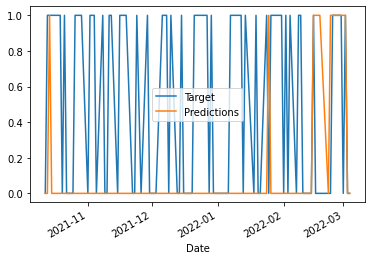

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()